In [1]:
# Import kaggle.json from google drive
# This snippet will output a link which needs authentication from any google account
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
    q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
# print(kaggle_api_key)
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!mkdir dogsbreeds_final

In [7]:
!kaggle competitions download -c dog-breed-identification -p /dogsbreeds_final/

  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 33.8MB/s]
  0% 0.00/281k [00:00<?, ?B/s]
100% 281k/281k [00:00<00:00, 38.1MB/s]
100% 346M/346M [00:03<00:00, 98.1MB/s]

 94% 324M/345M [00:02<00:00, 118MB/s]
100% 345M/345M [00:02<00:00, 128MB/s]


In [0]:
os.chdir("/dogsbreeds_final/")

In [9]:
!ls

labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [10]:
!unzip -q \*.zip


4 archives were successfully processed.


In [11]:
!ls

labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [2]:
import os
import numpy as np
from tqdm import tqdm
import cv2
from PIL import Image
import tensorflow as tf
import skimage
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.xception import Xception
from keras.layers import LeakyReLU
from keras.applications import InceptionResNetV2

Using TensorFlow backend.


In [0]:
import pandas as pd
PATH="/dogsbreeds_final/"
df = pd.read_csv(os.path.join(PATH,'labels.csv'))
df_test = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

**Load, Resize and preprocess the images **

In [5]:
targets_series = pd.Series(df['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

im_size = 32
x_train1 = []
y_train1 = []
x_test1 = []
i = 0 
new_shape = (128,128,3)

for f, breed in tqdm(df.values):
    img = cv2.imread('/dogsbreeds_final/train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    #print(label)
    #x_train1.append(cv2.resize(img, (im_size, im_size)))
    X_data_resized = resize(img, new_shape)
    x_train1.append(X_data_resized)
    #res = tf.keras.backend.resize_images(img, 32, 32, "channels_last",interpolation='bilinear')
    y_train1.append(label)
    i += 1
  

  0%|          | 0/10222 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 10222/10222 [02:47<00:00, 61.13it/s]


In [6]:
#new_shape = (32,32,3)

y_train_raw = np.array(y_train1, np.uint8)
x_train_raw = np.array(x_train1, np.float32) / 255.
x_testContest  = np.array(x_test1, np.float32) / 255.

num_class = y_train_raw.shape[1]

print(x_train_raw.shape)
print(y_train_raw.shape)   

(10222, 128, 128, 3)
(10222, 120)


**Split Data into Train and Test**

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

In [0]:
batch_size = 128
epochs = 20
learning_rate = 0.001

**Best performing Model**

In [40]:
model = Sequential()
model.add(BatchNormalization(input_shape=(128, 128, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_class, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_31 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 63, 63, 16)        64        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 30, 30, 32)        128       
__________

In [41]:
opt = optimizers.Adam(lr = learning_rate)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                  batch_size=batch_size,verbose=2, epochs=epochs, shuffle = True)

Train on 7155 samples, validate on 3067 samples
Epoch 1/20
 - 10s - loss: 4.6109 - acc: 0.0366 - val_loss: 4.5235 - val_acc: 0.0525
Epoch 2/20
 - 8s - loss: 4.0289 - acc: 0.1019 - val_loss: 4.2774 - val_acc: 0.0717
Epoch 3/20
 - 8s - loss: 3.6494 - acc: 0.1757 - val_loss: 4.1586 - val_acc: 0.0867
Epoch 4/20
 - 7s - loss: 3.2650 - acc: 0.2738 - val_loss: 4.1234 - val_acc: 0.0910
Epoch 5/20
 - 7s - loss: 2.8647 - acc: 0.3782 - val_loss: 4.1364 - val_acc: 0.0978
Epoch 6/20
 - 7s - loss: 2.4166 - acc: 0.5110 - val_loss: 4.0632 - val_acc: 0.1017
Epoch 7/20
 - 7s - loss: 1.9388 - acc: 0.6477 - val_loss: 4.1734 - val_acc: 0.0890
Epoch 8/20
 - 7s - loss: 1.4647 - acc: 0.7740 - val_loss: 4.1758 - val_acc: 0.0871
Epoch 9/20
 - 7s - loss: 1.0033 - acc: 0.8839 - val_loss: 4.1667 - val_acc: 0.0975
Epoch 10/20
 - 7s - loss: 0.6293 - acc: 0.9533 - val_loss: 4.3042 - val_acc: 0.0919
Epoch 11/20
 - 7s - loss: 0.3631 - acc: 0.9836 - val_loss: 4.3226 - val_acc: 0.0942
Epoch 12/20
 - 7s - loss: 0.1986 - a

**Best model score and loss**

In [42]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc*100)

Test loss: 4.5020759876053456
Test acc: 10.629279427121041


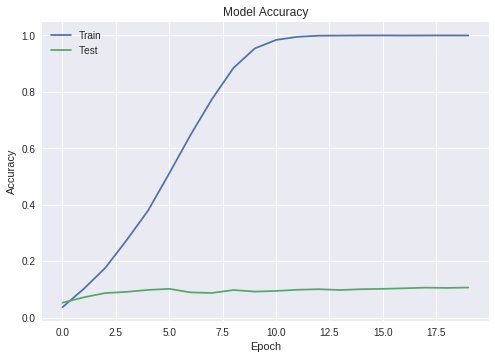

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

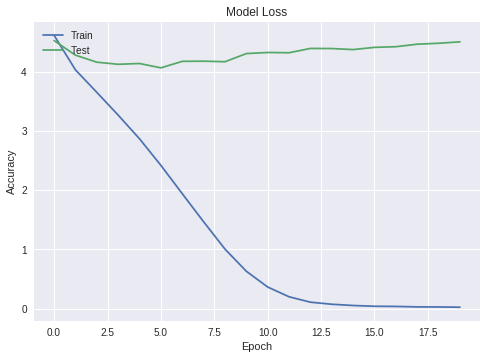

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Pre-trained Model Xception**

In [8]:
nTrain = 10000
#datagen = ImageGenerator(rescale=1.0/255)
#train_features  = np.zeros()
base_model = Xception(weights='imagenet',include_top= False ,input_shape=(128,128,3))
# Model structure
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_____________________________________

**Adding DogBreed data to Xception model**

In [47]:
x_train = base_model.predict(x_train)
x_val = base_model.predict(x_test)
print(x_train.shape)
print(x_val.shape)

(7155, 4, 4, 2048)
(3067, 4, 4, 2048)


In [0]:
model = Sequential()
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(num_class,activation='softmax'))
opt = optimizers.SGD(lr=.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [52]:
fit_m =model.fit(x_train,y_train, batch_size=32, epochs=150,validation_data=(x_val,y_test),shuffle=True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 7155 samples, validate on 3067 samples
Epoch 1/150
7155/7155 [==============================] - 7s 1ms/step - loss: 4.7892 - acc: 0.0087 - val_loss: 4.7887 - val_acc: 0.0062
Epoch 2/150
7155/7155 [==============================] - 4s 555us/step - loss: 4.7899 - acc: 0.0085 - val_loss: 4.7887 - val_acc: 0.0072
Epoch 3/150
7155/7155 [==============================] - 4s 557us/step - loss: 4.7898 - acc: 0.0075 - val_loss: 4.7886 - val_acc: 0.0078
Epoch 4/150
7155/7155 [==============================] - 4s 563us/step - loss: 4.7892 - acc: 0.0084 - val_loss: 4.7886 - val_acc: 0.0082
Epoch 5/150
7155/7155 [==============================] - 4s 563us/step - loss: 4.7896 - acc: 0.0094 - val_loss: 4.7885 - val_acc: 0.0082
Epoch 6/150
7155/7155 [==============================] - 4s 573us/step - loss: 4.7895 - acc: 0.0082 - val_loss: 4.7885 - val_acc: 0.0091
Epoch 7/150
7155/

**Changing Xception Base to improve the performance** 

In [0]:

model1 = Sequential()
for layer in base_model.layers:
        layer.trainable = False

model1.add(base_model)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(num_class, activation='softmax'))

In [0]:
opt = optimizers.Adam(lr = learning_rate)
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [15]:
fit_m =model1.fit(x_train,y_train, batch_size=32, epochs=50,validation_data=(x_test,y_test),shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 7155 samples, validate on 3067 samples
Epoch 1/50
7155/7155 [==============================] - 49s 7ms/step - loss: 4.2824 - acc: 0.1126 - val_loss: 4.7871 - val_acc: 0.0065
Epoch 2/50
7155/7155 [==============================] - 41s 6ms/step - loss: 3.3637 - acc: 0.3029 - val_loss: 4.7874 - val_acc: 0.0068
Epoch 3/50
7155/7155 [==============================] - 41s 6ms/step - loss: 2.9725 - acc: 0.4017 - val_loss: 4.7871 - val_acc: 0.0072
Epoch 4/50
7155/7155 [==============================] - 42s 6ms/step - loss: 2.6982 - acc: 0.4646 - val_loss: 4.7881 - val_acc: 0.0068
Epoch 5/50
7155/7155 [==============================] - 42s 6ms/step - loss: 2.4865 - acc: 0.5188 - val_loss: 4.7881 - val_acc: 0.0068
Epoch 6/50
7155/7155 [==============================] - 42s 6ms/step - loss: 2.3104 - acc: 0.5617 - val_loss: 4.7891 - val_acc: 0.0098
Epoch 7/50
7155/7155 [==============================] - 42s 6ms/step - loss: 2.1752 - acc: 0.5